In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater
from causalbenchmark.novo import misc

In [2]:
spark_generator = NewsHeadlines(locs=['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1')).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
setting_generation_prompt_template = \
'''We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired
- confounder variables may or may not be observable, and should always have at least two causal children (for example, a treatment and outcome variable) and no causal parents
- mediator variables may or may not be observable, and should always have at least one causal parent (for example, a treatment variable) and at least one causal child (for example, the outcome variable)
- collider variables may or may not be observable, and should always have at least two causal parents (for example, a treatment and outcome variable) and no causal children

Answer concisely and precisely in the desired format. Carefully complete each of these tasks in order.

1. Write a short description of what the article is about and what causal model make inform the reasoning behind an argument the might make.
2. Propose 1 outcome variable that the news article is either implicitly or explicitly addressing that people are most likely to be interested in studying, especially if people tend to have misconceptions about it
3. Propose 2 treatment variables that either directly or indirectly affect the selected outcome variable and are the most interesting to study
4. Propose 4 confounder variables that affect some reasonable combination of the outcome and treatment variables
5. Propose 3 mediator variables that affect and are affected by some reasonable combination of any other variables
6. Propose 2 collider variables that are affected by some reasonable combination of any other variables

Here is the beginning of the news article:
```
{spark}
```

The variables and causal graph should, where possible, use specific details such as names and locations mentioned in the article. Also, generally the variable value "0" should correspond to the negative, neutral, or control while the value "1" should correspond to the positive choice or active value.

Take a deep breath and think step-by-step about how you will do this.'''
graph_selection_prompt_template = \
'''1. Select some combination of 3-5 of the suggested confounder, mediator, and collider variables, in addition to the treatment and outcome variables to construct a realistic and interesting causal graph. Important: Make sure the causal graph is a DAG and that no node has more than three parents!
2.  List all the edges in the causal graph, and make sure to mention which edges are observable and which are not.
3. Provide a python list called `nodes` of all the nodes in the proposed graph. For each node, provide the following information in the form of a python dict:
- `name`: the name of the variable
- `description`: a short description of the variable
- `type`: the type of the variable, which can be one of the following: `outcome`, `treatment`, `confounder`, `mediator`, `collider`
- `observed`: a boolean value indicating whether the variable is observable or not
- `values`: a python list of the descriptions of the values the variable can take (corresponding to the index)
- `parents`: a python list of the names of the parents of the variable (make sure they match the corresponding `name` field of the parent nodes, and remember, there should not be more than three parents for any node)

Take a deep breath and think step-by-step about how you will do this.'''
stats_prompt_template = \
'''We have a causal bayes net based on the following article:

```
{spark}
```

Now we would like to estimate the probabilities of certain events.

Using commonsense, estimate the probabilities of the following events:

{prob_questions}

Where the variables are defined as:
{descriptions}

For each question above, answer with the lower and upper bound estimates of the probabilities as a python dictionary where the key corresponds to the question index in exactly the following format:

```python
probabilities = {{
  1: [0.3, 0.4],
  ...
}}
```

Answer concisely and precisely in the desired format.'''
verb_prompt_template = \
'''We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a news paper article or casual conversation, while still being semantically equivalent to the original variable and value.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {{variable}}.
2. We estimate {{subject}} [often/usually/sometimes/rarely/etc.] {{value}}.
3. There is a [number]% chance that {{value}}.
4. [number]% of {{domain}} {{value}}.
5. [number]% of the time {{value}}.
6. Conditional sentence: {{value}}, [some consequence].
7. Interventional: If {{value}}, [some effect].

{variable_description}

Here are some examples of verbalizations of the variable. For each of the templates fill in the blanks (and include 2-3 examples for each template). Format your response as a python dictionary. When replacing the key "value", make sure to include some examples for both values that the variables can take. For example, a variable "Smoking Rate" which takes the values "Low Smoking Rate"=0 and "High Smoking Rate"=1 can be verbalized like this:

```python
verbalizations = {{
  "Smoking Rate": {{
    1: {{"variable": ["the smoking rate", "proportion of smokers"]}},
    2: {{"subject": "people", "value": {{0: ["do not smoke", "are non-smokers"], 1: ["smoke", "are smokers"]}}}},
    3: {{"value": {{0: ["people do not smoke", "people are non-smokers"], 1: ["people smoke", "people are smokers"]}}}},
    4: {{"domain": "people", "value": {{0: ["do not smoke", "are non-smokers"], 1: ["smoke", "are smokers"]}}}},
    5: {{"value": {{0: ["the smoking rate decreases", "people stop smoking"], 1: ["the smoking rate increases", "people start smoking"]}}}},
    6: {{"value": {{0: ["For people that do not smoke", "Among non-smokers"], 1: ["For people that smoke", "Among smokers"]}}}},
    7: {{"value": {{0: ["people quite smoking", "people become non-smokers"], 1: ["people become smokers", "people take up smoking"]}}}},
  }},
  ...
}}
```

Answer concisely and precisely in the desired format, and only replace the blanks in curly braces. Do not add any additional comments or discussion. Most importantly, the verbalizations should not contain quantitative information like "often" or "rarely", and instead always assert the corresponding value.'''
question_prompt_template = \
'''We have a causal bayes net based on the following article:

```
{spark}
```

Now we would like to use this model to generate some interesting research questions:

1. Write a short two sentence introduction to describe motivation and purpose of the causal model to provide context to the questions in an conversational/debate setting. Where possible, include relevant details from the original article headline or related information you can infer therefrom. Avoid discussing specific structural properties or assumptions in the causal graph, and instead focus on the overall motivation and potential applications for the model. Refrain from mentioning words like "causal inference" or "model".
Make sure not to use any technical terms from causal inference so that the introduction is easy to understand even for a layperson, as if this were in a newspaper or casual discussion.
2. Write a short two sentence overview of the structure of the causal graph including noteworthy properties and assumptions. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and their relationships (including using terms like "confounder"/"confounding", "mediator"/"mediates") as long as you explain them in a way that is understandable to a layperson.
3. Verbalize an interesting "yes"/"no" question where the correct answer depends computation of each of the following quantities:

{query_description}

Where "| * |" is the absolute value and the definitions of "ATE('X')" (average treatment effect) and "CATE('X' | 'U'=u)" are:

ATE('X') = E['Y' | do('X' = 1)] - E['Y' | do('X' = 0)]
CATE('X' | 'U'=u) = E['Y' | 'U'=u, do('X' = 1)] - E['Y' | 'U'=u, do('X' = 0)]

Where 'X' is a treatment variable, 'Y' is the outcome variable, and 'U' is a confounder variable.

4. In addition to the questions and associated answers include a one sentence explanation for each question, and "wrong_explanation" which is just like the explanation but argues for the opposite answer.

The meanings of all the variables (all of which are binary) in the statistical model are:

{variable_description}

Answer in the form of a python dictionary in the following format:

```python
setting = {{
  "introduction": "[introduction]",
  "overview": "[overview]",
  "questions": {{
    1: {{"question": "[question]", "answer": "yes", "explanation": "[explanation]", "wrong_explanation": "[wrong_explanation]"}},
    ...
  }},
}}
```
Answer concisely and precisely in the desired format. Do not add any additional comments or discussion. Most importantly, do not use any technical terms from causal inference such as ATE or CATE in the questions and explanations so that everything is easy to understand even for a layperson.'''

In [4]:
ctx = Story(story_root=misc.data_root() / 'stories', story_id='test17')
# ctx = Story(story_root=misc.data_root() / 'stories')
ctx.populate_defaults(story_prompt_tempalte=setting_generation_prompt_template,
                      graph_prompt_template=graph_selection_prompt_template,
                      stats_prompt_template=stats_prompt_template,
                        verb_prompt_template=verb_prompt_template,
                        questions_prompt_template=question_prompt_template,
                      )
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 2494534#91220#1684065#6805333
print(ctx['seed'])
print(ctx['spark'])

2249235
Title: Emmanuel Macron promises a “direct discussion” with members of the citizens’ climate convention - Le Monde
Description: The president “could announce the final decisions” before the presentation planned for the end of January of the climate bill.
Original Language: French


In [5]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_story']
print(ctx['prompt_story'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired
- confounder variables may or may not be observable, and should always have at least two causal children (for example, a treatment

In [6]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
print(ctx['prompt_graph'])

1. Select some combination of 3-5 of the suggested confounder, mediator, and collider variables, in addition to the treatment and outcome variables to construct a realistic and interesting causal graph. Important: Make sure the causal graph is a DAG and that no node has more than three parents!
2.  List all the edges in the causal graph, and make sure to mention which edges are observable and which are not.
3. Provide a python list called `nodes` of all the nodes in the proposed graph. For each node, provide the following information in the form of a python dict:
- `name`: the name of the variable
- `description`: a short description of the variable
- `type`: the type of the variable, which can be one of the following: `outcome`, `treatment`, `confounder`, `mediator`, `collider`
- `observed`: a boolean value indicating whether the variable is observable or not
- `values`: a python list of the descriptions of the values the variable can take (corresponding to the index)
- `parents`: a p

In [7]:
#################################################


nodes = ctx['nodes']



#################################################
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
ctx['nodes'] = nodes

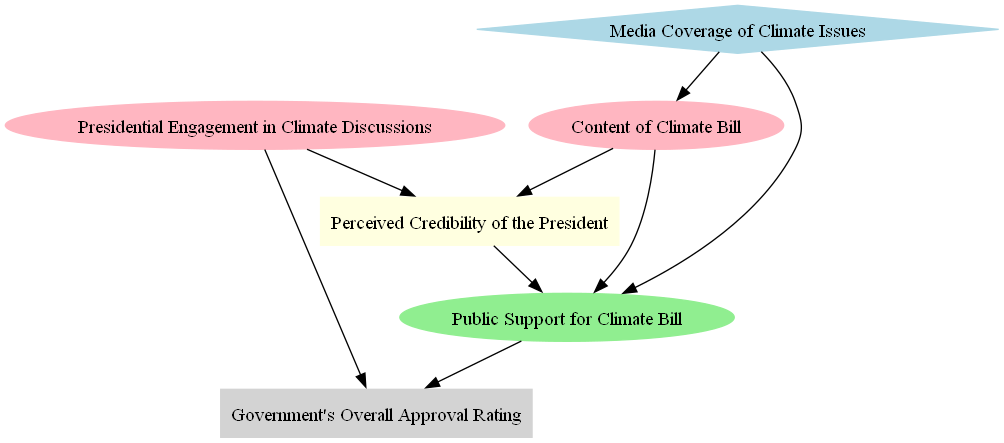

In [8]:
# G = ctx['graph']
# if 'graph' in ctx:
#     del ctx['graph']
# node_colors = {'treatment': 'lightcoral', 'outcome': 'lightgreen', 'confounder': 'lightblue', 'mediator': 'lightyellow', 'collider': 'lightgray'}
# colors = [node_colors[G.nodes[n]['type']] for n in G.nodes]
# plt.figure(figsize=(10, 6))
# pos = nx.circular_layout(G)
# nx.draw(G, pos, with_labels=True, node_color=colors, node_size=5000, font_size=10, font_weight='bold', edge_color='gray', arrowsize=20)
# plt.title('Causal Graph', size=15);
# plt.tight_layout();

dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [9]:
# if 'prompt_stats' in ctx:
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
print(ctx['prompt_stats'])

We have a causal bayes net based on the following article:

```
Title: Emmanuel Macron promises a “direct discussion” with members of the citizens’ climate convention - Le Monde
Description: The president “could announce the final decisions” before the presentation planned for the end of January of the climate bill.
Original Language: French
```

Now we would like to estimate the probabilities of certain events.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Presidential Engagement in Climate Discussions" is "Active engagement" (rather than "No engagement")?
2. what is the probability that "Media Coverage of Climate Issues" is "Extensive/Positive coverage" (rather than "Limited/Negative coverage")?
3. when "Media Coverage of Climate Issues" is "Limited/Negative coverage": what is the probability that "Content of Climate Bill" is "Perceived as effective/favorable" (rather than "Perceived as ineffective/unfavorable")?
4. when "Me

In [10]:
#################################################


probabilities = ctx['stats']


#################################################
ctx['stats'] = probabilities

In [11]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

variables = {}
for node in ctx['nodes']:
    if len(node['parents']):
        variables[node['name']] = ConditionalBernoulli([variables[parent] for parent in node['parents']])
    else:
        variables[node['name']] = Bernoulli(0.5)
net = BernoulliNetwork(variables)
# net

In [12]:
def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges), 1) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, conditions=conditions)[outcome].item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn

In [13]:
treatment1, treatment2 = [node['name'] for node in ctx['nodes'] if node['type'] == 'treatment']
t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

ate1, ate2, corr1, corr2 = mc_samples(100, make_ate_fn(treatment1, outcome), make_ate_fn(treatment2, outcome),
                                      make_corr_fn(treatment1, outcome), make_corr_fn(treatment2, outcome)).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

TypeError: string indices must be integers, not 'str'

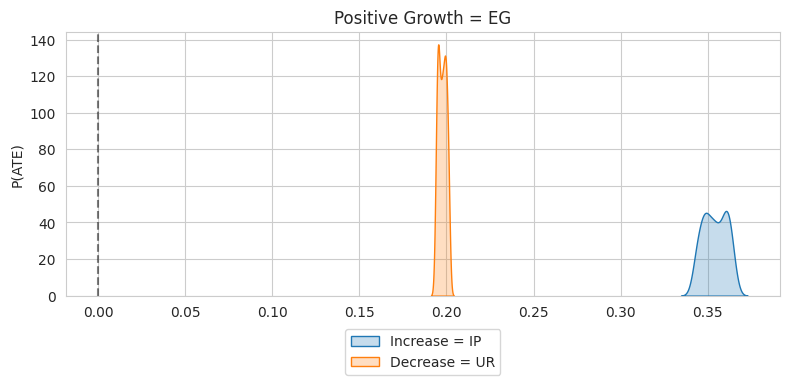

In [65]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

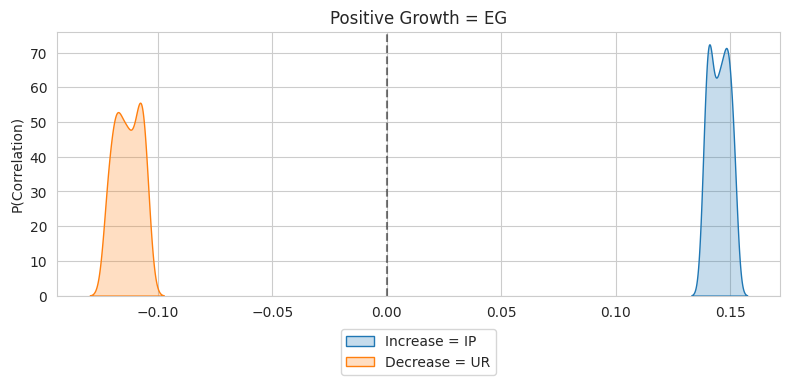

In [66]:
print(net.backdoor_estimand(treatment1['name'], outcome['name']))
print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [67]:
i = len(list(ctx._root.glob("*.json")))+1
path = ctx._root / f'test{i}'
while path.exists():
    i += 1
    path = ctx._root / f'test{i}'
ctx.save(path.stem)

PosixPath('/home/fleeb/workspace/code/cladder/novo-data/stories/test5.json')

In [68]:
print(net.backdoor_estimand(treatment1['name'], outcome['name']))
print(net.backdoor_estimand(treatment2['name'], outcome['name']))

('Presidential Engagement in Climate Discussions', 'Public Support for Climate Bill', [])
('Content of Climate Bill', 'Public Support for Climate Bill', ['Media Coverage of Climate Issues'])


In [63]:
qkey = random.choice(list(ctx['questions']['questions']))
qinfo = ctx['questions']['questions'][qkey]
query = ctx['queries'][int(qkey)-1]
print(query)
qinfo

         ATE    Correlation  Treatment           Outcome             Treatment Description         Outcome Description
------------  -------------  ------------------  ------------------  ----------------------------  ----------------------------
 0.6            -0.130868    Stimulative GEP     Increase IP         Government Economic Policies  Industrial Production
 0.5             0.0519683   Stimulative GEP     Decrease UR         Government Economic Policies  Unemployment Rate
 0.265794       -0.0779333   Stimulative GEP     High CC             Government Economic Policies  Consumer Confidence
 0.484723       -0.187706    Stimulative GEP     Positive Growth EG  Government Economic Policies  Economic Growth
 0.212796        0.0678635   Stimulative GEP     Good MP             Government Economic Policies  Market Performance
 0              -0.130868    Increase IP         Stimulative GEP     Industrial Production         Government Economic Policies
 0              -0.00680091  Increa

{'question': 'Does presidential engagement in climate discussions have a stronger effect on public support for the climate bill under extensive and positive media coverage than under limited or negative coverage?',
 'answer': 'yes',
 'explanation': 'The impact of presidential engagement on public support for the climate bill is likely to be more significant under extensive and positive media coverage compared to limited or negative coverage.',
 'wrong_explanation': 'The impact of presidential engagement on public support for the climate bill is similar regardless of whether media coverage is extensive and positive or limited and negative.'}

In [ ]:
# 1. One of the variables is {variable}.
# 2. We estimate {subject} [often/usually/sometimes/rarely/etc.] {value}.
# 3. There is a [number]% chance that {value}.
# 4. [number]% of {domain} {value}.
# 5. [number]% of the time {value}.
# 6. Conditional sentence: {value}, [some consequence].
# 7. Interventional: If {value}, [some effect].

In [111]:
rawverbs[outcome['name']]

{'1': {'variable': ['public support for the climate bill',
   "the climate bill's popularity"]},
 '2': {'subject': 'the climate bill',
  'value': {'0': ['lacks public support', 'is unpopular among the public'],
   '1': ['enjoys high public support', 'is popular among the public']}},
 '3': {'value': {'0': ['there is little public backing for the climate bill',
    'the climate bill is not popular'],
   '1': ['there is strong public support for the climate bill',
    'the climate bill is popular']}},
 '4': {'domain': 'public opinions',
  'value': {'0': ['do not favor the climate bill',
    'show disapproval of the climate bill'],
   '1': ['favor the climate bill', 'show approval of the climate bill']}},
 '5': {'value': {'0': ['the climate bill struggles to gain public support',
    'the climate bill faces public disapproval'],
   '1': ['the climate bill wins public support',
    'the climate bill is well-received by the public']}},
 '6': {'value': {'0': ['If public support for the climat

In [ ]:
ctx.include(get_verbalization_info);
verb_prompt_template = '''We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a news paper article or casual conversation, while still being semantically equivalent to the original variable and value.

Here are the templates that we use to verbalize the variables:

1. {{subject}} [often/usually/sometimes/rarely/etc.] {{value}}.
2. There is a [number]% chance that {{value}}.
3. [number]% of {{domain}} {{value}}.
4. [number]% of the time {{value}}.
5. Conditional sentence: {{value}}, [some consequence].
6. Interventional: If {{value}}, [some effect].

{variable_description}

Here are some examples of verbalizations of the variable. For each of the templates fill in the blanks (and include 2-3 examples for each template). Format your response as a python dictionary. For example, a variable "Smoking Rate" which takes the values "Low Smoking Rate" and "High Smoking Rate" can be verbalized like this:

```python
verbalizations = {{
  "Smoking Rate": {{
    "Low Smoking Rate": {{
      1: {{"subject": "people", "value": ["do not smoke", "are non-smokers"]}},
      2: {{"value": ["a person does not smoke", "people are non-smokers"]}}, 
      3: {{"domain": "people", "value": ["do not smoke", "are non-smokers"]}}, 
      4: {{"value": ["people do not smoke", "people are non-smokers"]}},
      5: {{"value": ["For people that do not smoke", "Among non-smokers"]}}, 
      6: {{"value": ["the smoking rate is decreased", "people stop smoking"]}},
    }},
    "High Smoking Rate": {{
      ...
    }}
  }},
  ...
}}
```

Answer concisely and precisely in the desired format, and only replace the blanks in curly braces. Do not add any additional comments or discussion. Most importantly, the verbalizations should not contain quantitative information like "often" or "rarely", and instead always assert the corresponding value.'''

tmpl = FixedTemplate('verb_prompt', verb_prompt_template)
ctx.include(tmpl,);
print(ctx['verb_prompt'])

In [29]:
# # ate1_template = '{ate1:.3f} = ATE({{treatments}[0]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][0]!r}))'
# # ate2_template = '{ate2:.3f} = ATE({{treatments}[1]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][0]!r}))'
# ate_tmpl = '{val:.3f} = ATE({treatment!r}) = E({outcome!r} | do({treatment!r}=1)) - E({outcome!r} | do({treatment!r}=0))'
# cate_tmpl = ('{val:.3f} = CATE({treatment!r} | {confounder!r}={cval}) = '
#              'E[{outcome!r} | {confounder!r}={cval}, do({treatment!r}=1)] - E[{outcome!r} | {confounder!r}={cval}, do({treatment!r}=0)]')
# for treatment, ate in [(treatment1, ate1.mean().item()), (treatment2, ate2.mean().item())]:
#     print(SimpleTemplater(ate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, val=ate))
# for (treatment, confounder, cval), cate in zip(*[cate_keys, cates]):
#     print(SimpleTemplater(cate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, confounder=confounder, cval=cval, val=cate.mean().item()))

In [44]:
#######################################################################

setting = {
    "introduction": "In light of the new decree by Prime Minister Giuseppe Conte, introducing a curfew in regions like Lombardy and Piedmont, it's crucial to understand how such decisions affect public health and behavior. This understanding can help in assessing the effectiveness of such measures and their impact on society.",
    "overview": "Our approach looks at how different factors like the curfew enforcement, public response, and healthcare capacity interplay with each other. It's like a web, where pulling one strand can cause movement in another, and we try to understand these relationships, like how public compliance might be influenced by the curfew or how all these affect public health.",
    "questions": {
        1: {"question": "Does implementing a curfew generally lead to better public health outcomes?", "answer": "yes", "explanation": "Implementing a curfew is likely to have a positive effect on public health by controlling the situation that necessitated the curfew.", "wrong_explanation": "Implementing a curfew might not significantly impact public health, as other factors could play a more dominant role."},
        2: {"question": "Is public non-compliance with a curfew typically associated with better public health outcomes?", "answer": "no", "explanation": "Public non-compliance with a curfew is generally not expected to contribute positively to public health outcomes.", "wrong_explanation": "Public non-compliance might actually lead to better public health outcomes as it indicates normalcy and lesser public panic."},
        3: {"question": "Is the positive impact on public health greater when a curfew is implemented than when the public complies with it?", "answer": "yes", "explanation": "The direct enforcement of a curfew is likely to have a stronger positive impact on public health than the variable level of public compliance.", "wrong_explanation": "Public compliance with the curfew could have a greater positive impact on public health than the mere implementation of the curfew."},
        4: {"question": "Do both the implementation of a curfew and the lack of public compliance have a combined negative effect on public health?", "answer": "no", "explanation": "While the lack of public compliance might negatively affect public health, the implementation of a curfew is expected to have a positive impact, which does not result in a combined negative effect.", "wrong_explanation": "The negative impacts of both non-compliance and curfew implementation may combine to deteriorate public health."},
        5: {"question": "In regions with high healthcare capacity, does implementing a curfew have a positive impact on public health?", "answer": "yes", "explanation": "In areas with strong healthcare systems, the implementation of a curfew is likely to further bolster public health outcomes.", "wrong_explanation": "Even in regions with high healthcare capacity, a curfew might not significantly improve public health outcomes."},
        6: {"question": "In regions with low healthcare capacity, does implementing a curfew have a positive impact on public health?", "answer": "yes", "explanation": "In regions where healthcare resources are limited, implementing a curfew can be crucial in preventing the overburdening of the healthcare system.", "wrong_explanation": "A curfew might not be as effective in regions with low healthcare capacity due to the already strained resources."},
        7: {"question": "In regions with high healthcare capacity, does high public compliance with the curfew lead to worse public health outcomes?", "answer": "no", "explanation": "In areas with ample healthcare resources, high public compliance with a curfew is expected to support or maintain good public health outcomes.", "wrong_explanation": "High compliance in regions with strong healthcare systems might lead to negative public health outcomes due to over-cautious behavior."},
        8: {"question": "In regions with low healthcare capacity, does high public compliance with the curfew lead to better public health outcomes?", "answer": "yes", "explanation": "In areas with limited healthcare resources, high compliance with curfew measures can play a critical role in maintaining or improving public health outcomes.", "wrong_explanation": "High public compliance in regions with low healthcare capacity might not significantly improve public health outcomes."},
        9: {"question": "Is the positive impact on public health of implementing a curfew greater in regions with low healthcare capacity compared to those with high capacity?", "answer": "no", "explanation": "The positive impact of a curfew is likely significant in both scenarios but not necessarily greater in regions with lower healthcare capacity.", "wrong_explanation": "Implementing a curfew in regions with low healthcare capacity might have a greater positive impact on public health compared to regions with high healthcare capacity."},
        10: {"question": "Does high public compliance with the curfew lead to better public health outcomes in regions with high healthcare capacity compared to those with low capacity?", "answer": "yes", "explanation": "High compliance in regions with strong healthcare infrastructure likely results in more pronounced improvements in public health compared to regions with weaker healthcare systems.", "wrong_explanation": "The impact of high public compliance on public health might be greater in regions with low healthcare capacity."},
        11: {"question": "Is the positive impact on public health from implementing a curfew less in regions with high healthcare capacity than the impact of high public compliance in these regions?", "answer": "no", "explanation": "The implementation of a curfew is likely to have a significant positive impact on public health, potentially more so than the variable of public compliance, even in regions with high healthcare capacity.", "wrong_explanation": "In regions with high healthcare capacity, the impact of public compliance might be more significant for public health than the implementation of a curfew."},
        12: {"question": "Is the positive impact on public health from implementing a curfew less in regions with low healthcare capacity than the impact of high public compliance in these regions?", "answer": "yes", "explanation": "In regions with low healthcare capacity, the impact of high public compliance might be more crucial for public health than the mere implementation of a curfew.", "wrong_explanation": "Implementing a curfew in regions with low healthcare capacity is likely to have a greater positive impact on public health than high public compliance."}
    },
}



#######################################################################
ctx['setting'] = setting

# Save Story

In [59]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from rake_nltk import Rake
import spacy
import random

In [61]:
example_texts = [val for var in raw_verbalization.values() for varval in var.values() for val in varval[4]['value']]
len(example_texts)

In [53]:
stop_words = set(stopwords.words('english'))
stop_words.update("'s", '|', 'I', "n't", "`s", "'s", 'n`t')

nlp = spacy.load('en_core_web_md')



In [79]:
text = "Covid-19 mortality rate is high"
text = random.choice(example_texts)
print(text)
doc = nlp(text)
subject, verb = None, None
for token in doc:
    if "subj" in token.dep_:
        subject = token.text
    # if "VERB" in token.pos_:
    #     verb = token.text
print(subject, verb)
noun_phrases = [chunk.text for chunk in doc.noun_chunks]
print(noun_phrases)

there is widespread healthcare availability in Moscow
None None
['widespread healthcare availability', 'Moscow']


In [21]:
old_prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence. For each set of questions, fill in the blank and then for each possible descriptor of the probability, provide a reasonable quantitative estimate for the lower and upper bounds of the probability that would be implied by that evidence if the variable took on the value corresponding to 1. Note that your estimates for each descriptor should conform to common sense and reflect the meaning of the variable taking on the value corresponding to 1.

For example, if the question is:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: ['low', 'high', 'very high']

1. "Tax Rate" can either be 0="Decreased" or 1="Increased".
2. "Vaccination Status" can either be 0="Not Vaccinated" or 1="Vaccinated".
...

You should answer in the following format:

```python
evidence = {{
  1: {{'blank': {{'Decreased': 'decreased taxes', 'Increased': 'increased taxes'}} 'implications': {{'low': [0.2, 0.4], 'high': [0.6, 0.8], 'very high': [0.8, 0.9]}}}},
  2: {{'blank': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}} 'implications': {{'low': [0.3, 0.5], 'high': [0.7, 0.9], 'very high': [0.85, 0.99]}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence using a few templates. For each template and variable, fill in the blank and then for each possible value the variable can take. Always use the present tense and make sure to use simple but precise language so the evidence can be communicated clearly. Also, only fill in the templates that make sense for the variable values.

For example, if the question is:

Template A: "The probability of {variable} is high."
Template B: "{variable} often."
Template C: "It is likely that {variable}."
Template D: "Few {subject} {variable}."

1. "Tax Rate": ["Decreased", "Increased"]
2. "Vaccination Status": ["Not Vaccinated", "Vaccinated"]
...

You should answer in the following format:

```python
evidence = {{
  1: {{'A': {{'variable': ['decreased taxes', 'increased taxes']}},
       'B': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'C': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'D': {{'subject': [], 'variable': ['taxes are decreased', 'taxes are increased']}}}},
  }},
  2: {{'variable': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

q_template = '{i}. "{variable}" can either be 0="{value}" or 1="{othervalue}".'

verbs = [
    'very low', 'low', 'moderate', 'high', 'very high',
    # 'extremely small', 'small', 'large', 'extremely large',
    'significant', 'negligible', 'substantial', 'insignificant', 'considerable',
    # 'improbable', 'likely', 'probable', 'unlikely', 'certain',
]

In [22]:
nodes = ctx['nodes']
qlines = []
i = 1
for node in nodes:
    v0, v1 = node['values']
    qlines.append(q_template.format(i=i, variable=node['name'], value=v1, othervalue=v0))
    i += 1
questions = '\n'.join(qlines)

In [23]:
tmpl = SimpleTemplater(prompt_template)
tmpl.keys

{'descriptions', 'descriptor', 'descriptors', 'questions', 'spark'}

In [24]:
# print(tmpl.fill_in(dict(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions)))
print(prompt_template.format(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions))

We have a causal bayes net based on the following article:

```
Title: ARM takeover: Qualcomm interested in participating - heise online
Description: If nothing comes of Nvidia's $40 billion ARM takeover, a consortium of several manufacturers could act as investors.
Original Language: German
```

And, for additional context, here are the variables and their descriptions:

"Qualcomm_Participation" means "Participation of Qualcomm in ARM takeover"
"Regulatory_Approval" means "Regulatory approval for ARM takeover"
"Global_Economic_Conditions" means "Current global economic conditions"
"Nvidia_Takeover_Success" means "Success of Nvidia's ARM takeover attempt"
"Investment_Strategy" means "Investment strategy adopted by Qualcomm"
"Tech_Innovation" means "Level of technological innovation in the market"
"Market_Competition" means "Level of market competition in the tech industry"
"Stock_Market_Response" means "Stock market response to the takeover and market conditions"

Now we would like to 

In [ ]:
line_template = 'The probability that __ is {quantity}'

In [120]:
evidence = {
  1: {
    'blank': {'Stimulative': 'stimulative government economic policies', 'Restrictive': 'restrictive government economic policies'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  2: {
    'blank': {'Increase': 'an increase in industrial production', 'Decrease': 'a decrease in industrial production'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  3: {
    'blank': {'Decrease': 'a decrease in the unemployment rate', 'Increase': 'an increase in the unemployment rate'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  4: {
    'blank': {'High': 'high consumer confidence', 'Low': 'low consumer confidence'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  5: {
    'blank': {'Positive Growth': 'positive economic growth', 'No Growth': 'no economic growth'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  6: {
    'blank': {'Good': 'good market performance', 'Poor': 'poor market performance'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  }
}

all(e1['implications'] == e2['implications'] for e1, e2 in combinations(evidence.values(), 2))


True

In [121]:
print(ctx['spark'])

Title: China's economy grows 4.9% while the rest of the world is crippled by coronavirus - Daily Mail
Description: China's economy has grown 4.9 percent in the third quarter from last year proving the country is back to its pre-pandemic trajectory as industrial production is up and unemployment is down.
Original Language: English


In [ ]:
setting = {
    "introduction": "In light of China's notable economic growth of 4.9% amidst the global coronavirus pandemic, as reported by the Daily Mail, this causal model seeks to unravel the underlying factors contributing to this growth. It aims to provide insights into how different aspects such as industrial production and unemployment rates have played a role in shaping China's economic trajectory during this period.",
    "overview": "Our causal graph is a simplified representation of the complex interplay between various economic factors. It includes variables like government policies, industrial production, and unemployment rates, each affecting the other in unique ways. For instance, government policies can be a confounder, affecting both unemployment and industrial production, while consumer confidence acts as a mediator, reflecting the impact of industrial changes on the overall economic growth.",
    "questions": {
        1: {"question": "Does an increase in industrial production have a positive effect on China's economic growth?", "answer": "yes", "explanation": "Given the economic context, an increase in industrial production likely contributes positively to economic growth.", "inequality": "ATE(IP) > 0"},
        2: {"question": "Is the positive impact of decreasing unemployment on economic growth greater than that of increasing industrial production?", "answer": "no", "explanation": "Industrial production typically has a more direct and significant impact on economic growth compared to changes in unemployment rates.", "inequality": "ATE(UR) > ATE(IP)"},
        3: {"question": "Does a decrease in the unemployment rate positively influence China's economic growth?", "answer": "yes", "explanation": "Lower unemployment generally leads to higher consumer spending and economic growth.", "inequality": "ATE(UR) > 0"},
        4: {"question": "Is the impact of industrial production on economic growth stronger than the influence of government economic policies?", "answer": "yes", "explanation": "While government policies set the stage, industrial production is a more direct driver of economic growth.", "inequality": "ATE(IP) > ATE(GEP)"},
        5: {"question": "Does a stimulative government policy have a greater positive effect on economic growth than an increase in industrial production?", "answer": "no", "explanation": "Industrial production, being a direct economic activity, likely has a stronger immediate impact on economic growth than general government policies.", "inequality": "ATE(GEP) > ATE(IP)"}
    },
}


In [227]:
import pandas as pd
from dowhy import CausalModel
from networkx.drawing.nx_pydot import write_dot

In [226]:
G = nx.DiGraph()
for var in net.vars:
    G.add_node(var.name)
    for parent in var.parents:
        G.add_edge(parent.name, var.name)
G

In [127]:
def convert_to_dot(nodes):
    # Start the DOT graph definition
    dot_graph = "digraph {\n"

    # Iterate over nodes to add them to the graph
    for node in nodes:
        dot_graph += f'    "{node["name"]}" [label="{node["name"]}: {node["description"]}"];\n'

        # Add edges from parents to this node
        for parent in node.get("parents", []):
            dot_graph += f'    "{parent}" -> "{node["name"]}";\n'

    dot_graph += "}\n"
    return dot_graph

In [ ]:
net

In [129]:
print(ctx['descriptions'])

"GEP" means "Government Economic Policies"
"IP" means "Industrial Production"
"UR" means "Unemployment Rate"
"CC" means "Consumer Confidence"
"EG" means "Economic Growth"
"MP" means "Market Performance"


In [221]:
# Create a dummy DataFrame
# The columns should match the nodes in your causal graph
dummy_data = pd.DataFrame({
    'EG': [0],   # Economic Growth
    'IP': [0],   # Industrial Production
    'UR': [0],   # Unemployment Rate
    'GEP': [0],  # Government Economic Policies
    'CC': [0],   # Consumer Confidence
    'MP': [0]    # Market Performance
})

# Define your DOT graph (use the function from the previous response)
dot_graph = convert_to_dot(nodes)

# Instantiate the CausalModel with dummy data
model = CausalModel(
    data=dummy_data,
    treatment='CC',  # Replace with your treatment variable name
    outcome='EG',      # Replace with your outcome variable name
    graph=dot_graph
)

identified_estimand = model.identify_effect()
print(identified_estimand)

from sympy import pretty

# # Assuming 'identified_estimand' is the object returned by model.identify_effect()
# 
# # Print the basic information about the estimand
# print("Estimand Identifier:", identified_estimand.identifier)
# print("Estimand Type:", identified_estimand.estimand_type)
# 
# # Accessing the estimands attribute
# estimands_info = identified_estimand.estimands
# 
# # Displaying the estimands information
# print("Estimands Information:")
# print(estimands_info)

identified_estimand.backdoor_variables, identified_estimand.default_backdoor_id

ERROR:dowhy.causal_graph: Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[EG|UR,IP])
d[CC]             
Estimand assumption 1, Unconfoundedness: If U→{CC} and U→EG then P(EG|CC,UR,IP,U) = P(EG|CC,UR,IP)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


({'backdoor1': ['UR', 'IP', 'GEP'],
  'backdoor2': ['UR', 'IP'],
  'backdoor': ['UR', 'IP']},
 'backdoor2')

In [222]:
sym = identified_estimand.estimands[identified_estimand.default_backdoor_id]['estimand']
sym

  d               
─────(E[EG|UR,IP])
d[CC]             

In [223]:
print(pretty(sym))

  d               
─────(E[EG|UR,IP])
d[CC]             


In [224]:
do = sym.args[1][0].args[0][0].name
exp = sym.args[0].args[0].name
if '|' in exp:
    outcome, cond = exp.split('|')
    cond = cond.split(',')
else:
    outcome = exp
    cond = []
    
print(outcome, do, cond)

EG CC ['UR', 'IP']


In [229]:
dummyvars = 'uvwxyz'
assert len(cond) <= len(dummyvars)
psum = ''
condsuffix = ''
if len(cond):
    psum = ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))
    psum = f'E_{{{psum}}} '

    condsuffix = ',' + ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))

expr = f'{psum}{"[ " if len(cond) else ""}p({outcome}=1 | {do}=1{condsuffix}) - p({outcome}=1 | {do}=0{condsuffix}){" ]" if len(cond) else ""}'

# expr = (f'{psum}{" [ " if len(cond) else ""}p({outcome} | {do}=1{", " + ", ".join(cond) if len(cond) else ""}) - p({outcome} | {do}=0{", " + ",".join(cond) if len(cond) else ""}){" ]" if len(cond) else ""}')
print(f'ATE({do} -> {outcome}) = {expr}')

ATE(CC -> EG) = E_{UR=u,IP=v} [ p(EG=1 | CC=1,UR=u,IP=v) - p(EG=1 | CC=0,UR=u,IP=v) ]


In [153]:
sym.variables[0]

AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'name'

In [154]:
expr = sym.expr
expr

In [159]:
e = expr.args[0]

In [160]:
terms = sym.as_terms()
terms

⎛⎡⎛  d               ⎛                ⎛  d              ⎞⎞⎞⎤    ⎞
⎜⎢⎜─────(E[EG|GEP]), ⎜(1.0, 0.0), (), ⎜─────(E[EG|GEP]),⎟⎟⎟⎥, []⎟
⎝⎣⎝d[UR]             ⎝                ⎝d[UR]            ⎠⎠⎠⎦    ⎠

In [161]:
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(Expectation(EG|GEP), [UR])
Coefficient: ((1.0, 0.0), (), (Derivative(Expectation(EG|GEP), [UR]),))


In [164]:
from sympy import symbols, Derivative, Function

# Define your symbols
EG, GEP, UR = symbols('EG GEP UR')

# Define the expected value function
E = Function('E')(EG, GEP)

# Define the derivative
deriv = Derivative(E, UR)

# Extract terms from the derivative
terms = deriv.as_terms()

# Process the terms to extract variable names and relationships
# terms is a tuple, where the first element contains the terms
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(E(EG, GEP), UR)
Coefficient: ((1.0, 0.0), (1,), ())


In [167]:
deriv

In [166]:
E.args